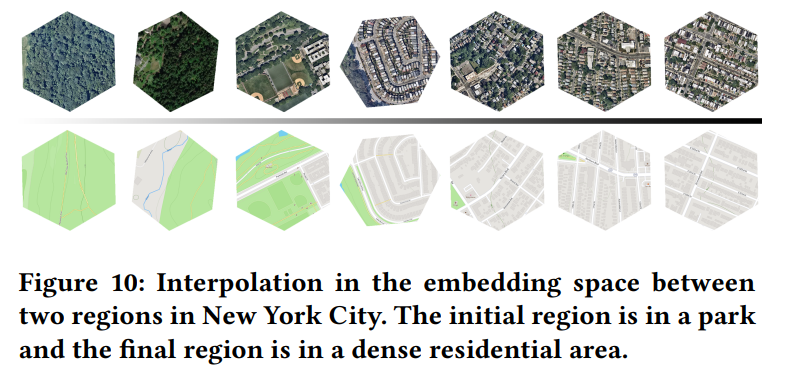

In [ ]:
%pip install -q open_clip_torch

In [1]:
%%capture
%env AWS_REQUEST_PAYER=requester

---

In [143]:
from rastervision.core.box import Box
from rastervision.core.data import RasterioSource

from tqdm.auto import tqdm
import rasterio as rio
import numpy as np
import torch
from torch.nn import functional as F
import geopandas as gpd
from matplotlib import pyplot as plt
import seaborn as sns
sns.reset_defaults()

---

## Load embeddings

In [3]:
# !aws s3 cp s3://raster-vision-ahassan/naip/skyscript_naip_MA_400_400.pt .
# !aws s3 cp s3://raster-vision-ahassan/naip/skyscript_naip_MA_800_800.pt .
# !aws s3 cp s3://raster-vision-ahassan/naip/skyscript_naip_MA_1600_1600.pt .

In [4]:
embs_400 = torch.load('data/skyscript_naip_MA_400_400.pt')
# embs_800 = torch.load('skyscript_naip_MA_800_800.pt')
# embs_1600 = torch.load('skyscript_naip_MA_1600_1600.pt')
embs_400.shape,  #embs_800.shape, #embs_1600.shape

(torch.Size([563379, 768]),)

In [166]:
img_embs = embs_400

---

## Load chip windows

In [5]:
# !aws s3 cp s3://raster-vision-ahassan/naip/naip_MA_400_400_w_uris.json .
# !aws s3 cp s3://raster-vision-ahassan/naip/naip_MA_800_800_w_uris.json .
# !aws s3 cp s3://raster-vision-ahassan/naip/naip_MA_1600_1600_w_uris.json .

In [6]:
windows_df_400 = gpd.read_file('data/naip_MA_400_400_w_uris.json')
# windows_df_800 = gpd.read_file('naip_MA_800_800_w_uris.json')
# windows_df_1600 = gpd.read_file('naip_MA_1600_1600_w_uris.json')

---

## Load model

In [7]:
import open_clip

model_name = 'ViT-L-14'
model, _, preprocess = open_clip.create_model_and_transforms(model_name)
tokenizer = open_clip.get_tokenizer(model_name)

print('#params: ', f'{sum(p.numel() for p in model.parameters()):,}')

INFO:root:Loaded ViT-L-14 model config.


#params:  427,616,513


In [8]:
ckpt_path = 'data/SkyCLIP_ViT_L14_top50pct/epoch_20.pt'
ckpt = torch.load(ckpt_path, map_location='cpu')['state_dict']
ckpt = {k[len('module.'):]: v for k, v in ckpt.items()}
message = model.load_state_dict(ckpt)
model = model.eval()

## Search

In [9]:
uris = set(windows_df_400.uri)
_uri_to_rs = {}

In [25]:
def uri_to_rs(uri: str):
    if uri not in _uri_to_rs:
        _uri_to_rs[uri] = RasterioSource(
            uri, channel_order=[0, 1, 2], allow_streaming=True)
    return _uri_to_rs[uri]

In [32]:
def emb_idx_to_chip(i, windows_df, out_shape=(400, 400)):
    i = int(i)
    uri = windows_df.uri.iloc[i]
    window_geom = windows_df.geometry.iloc[i]
    window = Box.from_shapely(window_geom)
    rs = uri_to_rs(uri)
    chip = rs.get_chip_by_map_window(window, out_shape=out_shape)
    return chip

In [27]:
def show_top_chips(chip_scores,
                   windows_df,
                   top_inds=None,
                   nrows=5,
                   ncols=5,
                   figsize=(12, 12),
                   w_pad=-2.5,
                   h_pad=-2.5):
    plt.close('all')
    fig, axs = plt.subplots(nrows, ncols, figsize=figsize)
    fig.tight_layout(w_pad=w_pad, h_pad=h_pad)
    if top_inds is None:
        top_inds = torch.topk(chip_scores, axs.size).indices
    for ax, i in zip(tqdm(axs.flat), top_inds):
        chip = emb_idx_to_chip(i, windows_df)
        ax.imshow(chip)
    for ax in axs.flat:
        ax.axis('off')
    plt.show()
    return fig

In [33]:
def get_chip_scores(text_queries, embs):
    assert len(text_queries) == 1
    text_emb = get_text_emb(text_queries)
    chip_scores = _get_chip_scores(text_emb, embs)
    return chip_scores


def get_chip_scores_pca(text_queries, embs, pca, num_pcs):
    assert len(text_queries) == 1
    text_emb = get_text_emb(text_queries)
    text_emb_pca = pca.transform(text_emb)[:, num_pcs]
    chip_scores = _get_chip_scores(text_emb, embs)
    return chip_scores


def get_text_emb(text_queries):
    with torch.inference_mode():
        text = tokenizer(text_queries)
        text_emb = model.encode_text(text)
        text_emb /= text_emb.norm(dim=-1, keepdim=True)
        text_emb = text_emb.cpu()
    return text_emb


def _get_chip_scores(text_emb, image_embs):
    with torch.inference_mode():
        chip_scores = torch.cosine_similarity(text_emb, image_embs)
    return chip_scores

In [180]:
q1 = 'dense forest'
q2 = 'large parking lot'
q = q1 + ' and ' + q2

  0%|          | 0/8 [00:00<?, ?it/s]

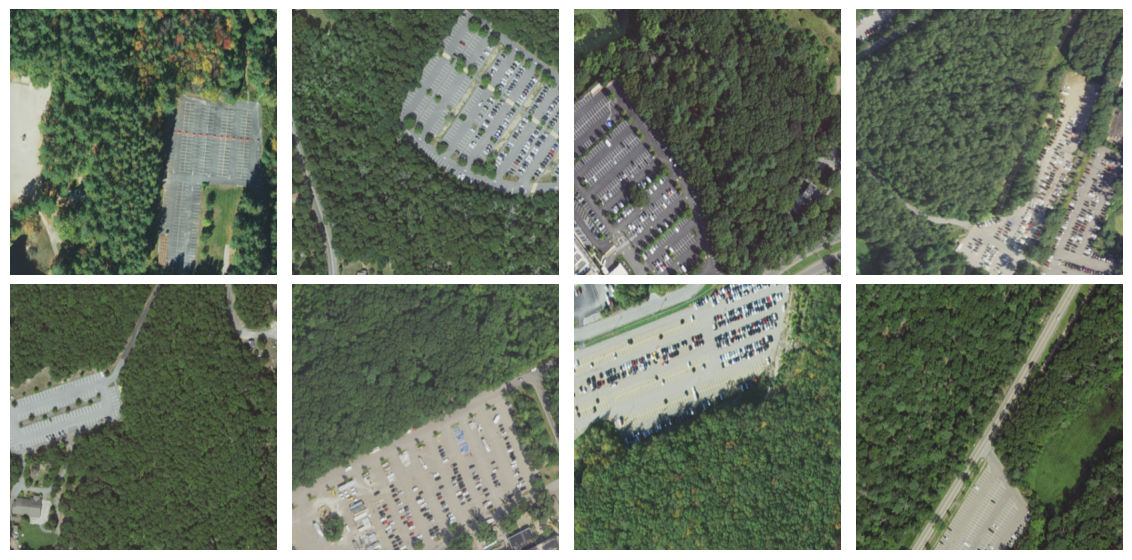

In [181]:
chip_scores_400 = get_chip_scores([q], embs_400)
_ = show_top_chips(
    chip_scores_400,
    windows_df_400,
    nrows=2,
    ncols=4,
    figsize=(12, 6),
    w_pad=-(12 / 4),
    h_pad=-(6 / 4))

---

In [ ]:
q = 'dense forest'
text_emb = get_text_emb([q])
chip_scores = _get_chip_scores(text_emb, img_embs)
top_inds = torch.topk(chip_scores, 1).indices

---

In [182]:
q1 = 'dense forest'
q2 = 'large parking lot'

In [183]:
text_emb1 = get_text_emb([q1])
text_emb2 = get_text_emb([q2])

In [ ]:
# text_emb1 * 1.0 + text_emb2 * 0.0
# text_emb1 * 0.8 + text_emb2 * 0.2
# text_emb1 * 0.6 + text_emb2 * 0.4
...
# text_emb1 * 0.0 + text_emb2 * 1.0

In [184]:
chips_all = []
alphas = np.linspace(0, 1, 6)
with tqdm(alphas) as bar:
    for alpha in bar:
        text_emb = (1 - alpha) * text_emb1 + alpha * text_emb2
        text_emb /= text_emb.norm(dim=-1, keepdim=True)
        chip_scores = _get_chip_scores(text_emb, img_embs)
        top_inds = torch.topk(chip_scores, 1).indices
        chips = [emb_idx_to_chip(i, windows_df_400) for i in top_inds]
        chips_all.append(chips)

  0%|          | 0/6 [00:00<?, ?it/s]

INFO:botocore.tokens:Loading cached SSO token for rv
INFO:botocore.tokens:Loading cached SSO token for rv
INFO:botocore.tokens:Loading cached SSO token for rv
INFO:botocore.tokens:Loading cached SSO token for rv


In [ ]:
plt.close('all')
nrows = len(chips_all[0])
ncols = len(chips_all)
fig, axs = plt.subplots(
    1,
    len(chips_all),
    figsize=(ncols * 2, 5),
    squeeze=True,
    sharex=True,
    sharey=True)
fig.tight_layout(w_pad=-1.25, h_pad=-2)
for ax, chip_row, alpha in zip(axs, chips_all, alphas):
    ax.imshow(chip_row[0])
    ax.set_title(
        f'{q1[:17]:<18}: {1-alpha:.2f}\n{q2[:17]:<18}: {alpha:.2f}', 
        fontsize=10, 
        fontfamily='Ubuntu Mono', 
        loc='left',
    )
    ax.axis('off')
plt.show()

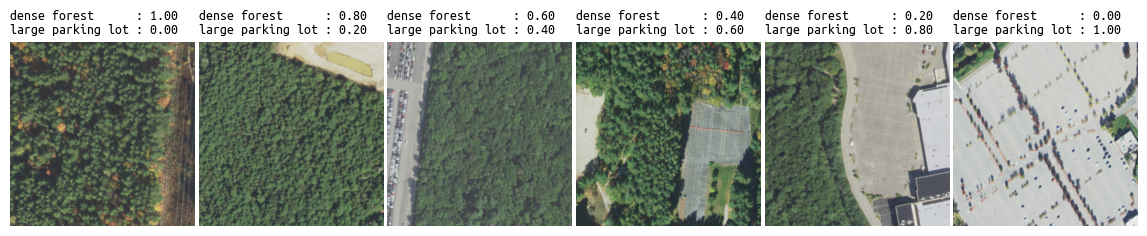

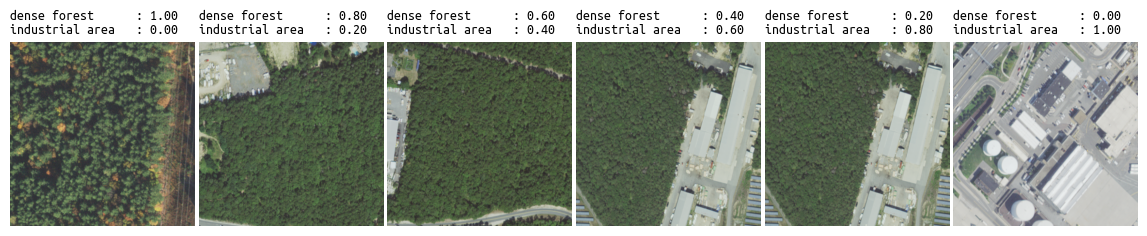

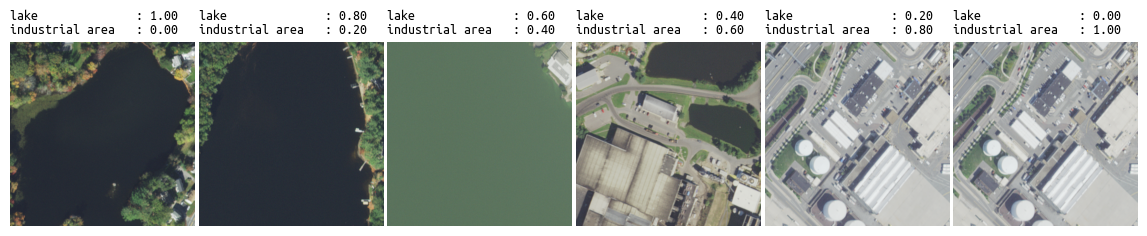

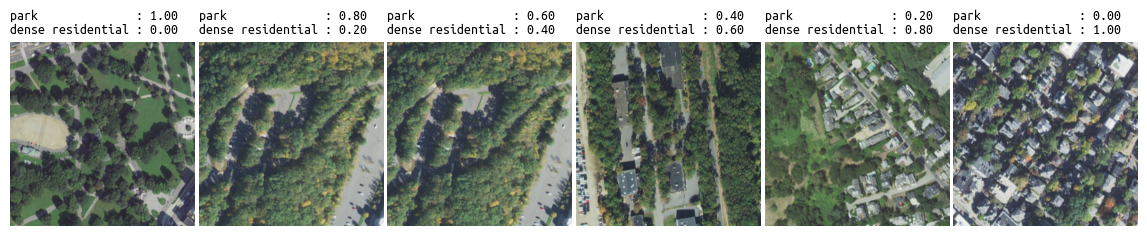